In [1]:
%run stdPackages.ipynb

## 1. Set up and solve model

#### Input data covers:
* Data on worker-to-retiree ratios $\nu_t$
* Set $X_i = A_t = 1$ for now (consider whether we need this for other calibration purposes).
* Set $\alpha$ to measure factor income shares.
* Set $\xi$ to reflect Frisch elasticity (measured as individual response to after-tax wages).
* Estimate of income distribution and working hours $(\gamma_i, \eta_i, X_i)$.
* Share of retirees only receiving minimum pensions $\gamma_u$.
* Set $\theta$ to reflect ratio of replacement rates at half mean and mean wages.
* Define $\epsilon$ from the ratio of universal to full pensions. In particular, we note that the universal coverage relative to an average income household is:
    $$\begin{align}
        \dfrac{b_t^u}{b_t^{average}} = (1-\epsilon)(1-\theta).
    \end{align}$$
    So, given $\theta$, we can set $\epsilon$ from
    $$\begin{align}
        \epsilon =1- \dfrac{b_t^u}{b_t^{average}(1-\theta)}
    \end{align}$$
    Also, note that unemployed households per construction receives less than any working households $i$:
    $$\begin{align}
        b_t^i - b_t^u = \left(\theta h_{t-1}^i \eta_i + \epsilon h_{t-1} \right) \overline{b}_t
    \end{align}$$
* Set $\beta_i$ to reflect distribution in savings rates across the income distribution / MPC's across the income distribution.
* Set $\chi_1$ to reflect the ratio of informal-to-formal income. Set $\chi_2 = .1 \chi_1$ for now.
* Set $\beta_u = min(\beta_i)$ (we don't have distribution of $\beta$'s, so this is not that important here).
* Target pension tax rate in a given year.

### 1.1. Raw data and direct input calibration

In [2]:
dates = pd.Index([1950, 1980, 2010, 2040, 2070, 2100], name = 't')
ν = np.array([1.497025777, 1.365562914, 1.20756547, 1.110843373, 1.072547602, 1.0725])
T = len(ν)
A = np.ones(T)
α = .5
ξ = .35
θ = .815
epsilon = .56 # I am not sure about this one 

### 1.2. Calibration of heterogeneity

Heterogeneity for Argentina:
* $\gamma$: Equal shares of the population.
* $zx$: Working hours relative to average.
* $z\eta$: Income relative to average.

In [3]:
γ = np.full((4, ), 0.25) # four equally large shares
ni = len(γ) # number of types in this case
hours = np.array([38.6, 41.8, 43.4, 46.8]) 
income= np.array([618.6, 945.5, 1278.6, 2341.6])
zx = hours/hours.mean() # normalized data
zη = income/income.mean() # normalized data
sRates = np.full(ni, 0.207) # no heterogeneity in saving propensities

Now, calibrate parameteres:

1. The vector of $(\eta_i/X_i)^{\xi}$ is proportional to eigenvector $\textbf{y}^x$ - i.e. set $(\eta_i/X_i)^{\xi} = y_i^x$.
2. The vector of $(\eta_i^{1+\xi}/X_i^{\xi})$ is proportional to the eigenvector $\textbf{y}^{\eta}$ - i.e. set $\eta_i^{1+\xi}/X_i^{\xi} = k y_i^{\eta} $, where $k>0$ is some constant.
3. We then have $\eta_i =k y_i^{\eta} / y_i^x$ and $(\eta_i/X_i)^{\xi} = y_i^x$. Use $k$ to normalize such that 
$$\begin{align}
    \sum_i \gamma_i \eta_i^{1+\xi}/X_i^{\xi} = 1 \qquad \Rightarrow \qquad k = \dfrac{1}{\sum_i \gamma_i y_i^{\eta}}.
\end{align}$$

Find eigenvectors:

In [4]:
valx, vecx = scipy.sparse.linalg.eigs(zx.reshape(ni,1) * γ.reshape(1,ni), k=1)
valη, vecη = scipy.sparse.linalg.eigs(zη.reshape(ni,1) * γ.reshape(1,ni), k=1)
yx, yη = abs(np.real(vecx)).reshape(ni), abs(np.real(vecη)).reshape(ni) # this assumes that all coordinates in eigenvector are either positive or negative; this should be the case

Calibrate parameters:

In [5]:
η = yη/(yx*sum(γ*yη))
X = η/yx**(1/ξ)

Set uniform $\beta$s:

In [6]:
β = sRates/(1-sRates)

### 1.3. Calibration of unemployment

Unemployed households:

In [7]:
γu =.32
χ1 = 0.3089
χ2 = 0.25 * χ1
βu= min(β) 

### 1.4. Calibration of $\omega$ to target pension tax rate

We initialize the model with parameter values by calling:

In [8]:
model = vectorized.infHorizon(ni = ni, T = T, **{'α': α, 'A': A, 'ν': ν, 'η': η, 'γ': γ, 'X': X, 'β': β, 'βu': βu, 'ξ': ξ, 'epsilon': epsilon, 'θ': θ, 'γu': γu, 'χ1': χ1, 'χ2': χ2})

Target a specific tax rate (e.g. in 14.2% in 2010):

In [9]:
τ0 = 0.142
t0 = dates.get_loc(2010)
model.calibrateω(τ0, t0, x0 = 1); # calibrate ω to target pension rate

Store the solution including various other helpful variables in the ```self.database``` by calling:

In [10]:
model.reportAll()

## 2 Experiments:

Provide some labels to call the $i$ types when plotting:

In [11]:
typeLabels = {0: '1st Quartile', 1: '2nd Quartile', 2: '3rd Quartile', 3: '4th Quartile'}

Auxiliary functions used for plotting:

In [12]:
def addYears(x, copy = True):
    """ Replace integer set 't' (from 0 to T) with years in 'dates' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(pd.Series(dates.values, index = model.db['t'])).rename('')
    elif isinstance(x, (pd.DataFrame, pd.Series)):
        x.index = addYears(x.index, copy = False)
        return x
def adjLabels(x, copy = True):
    """ Replace integer set 'i' (from 0 to ni) with labels in 'typeLabels' """
    if copy:
        x = x.copy()
    if isinstance(x, pd.Index):
        return x.map(typeLabels)
    elif isinstance(x, pd.Series):
        x.index = adjLabels(x.index, copy = False)
    elif isinstance(x, pd.DataFrame):
        x.columns = adjLabels(x.columns, copy = False)
    return x

Store variables across a parameter shock:

In [13]:
def extractDf(sol, x, grid):
    return addYears(pd.concat([soli[x] for soli in sol.values()], axis=1)).set_axis(grid, axis = "columns")

Store initial values before experiments:

In [14]:
initialSolution = model.db.copy() # default values to start experiments from

*Vary $\epsilon$ and report solution:*

In [15]:
ϵgrid = pd.Index([round(x,1) for x in np.linspace(0,1,11)], name = '$\epsilon$')
ϵsol = dict.fromkeys(ϵgrid)
for ϵ in ϵgrid:
    model.updateAndSolve(**{'epsilon': ϵ})
    model.reportAll()
    ϵsol[ϵ] = model.db.copy()

*Vary $\theta$ and report solution:*

In [16]:
model.db = initialSolution.copy() # reset to starting values
θgrid = pd.Index([round(x,1) for x in np.linspace(0,1,11)], name = '$\\theta$')
θsol = dict.fromkeys(θgrid)
for θ in θgrid:
    model.updateAndSolve(**{'θ': θ})
    model.reportAll()
    θsol[θ] = model.db.copy()

## 3. Illustrations

### 3.1. PEE taxes as a function of pension design

Extract solution for $\tau_t$ for the different values of $\epsilon$ and $\theta$:

In [17]:
τϵ = extractDf(ϵsol, 'τ', ϵgrid)
τθ = extractDf(θsol, 'τ', θgrid)

Plot $\tau_t$ as a function of $\theta$ and $\epsilon$:

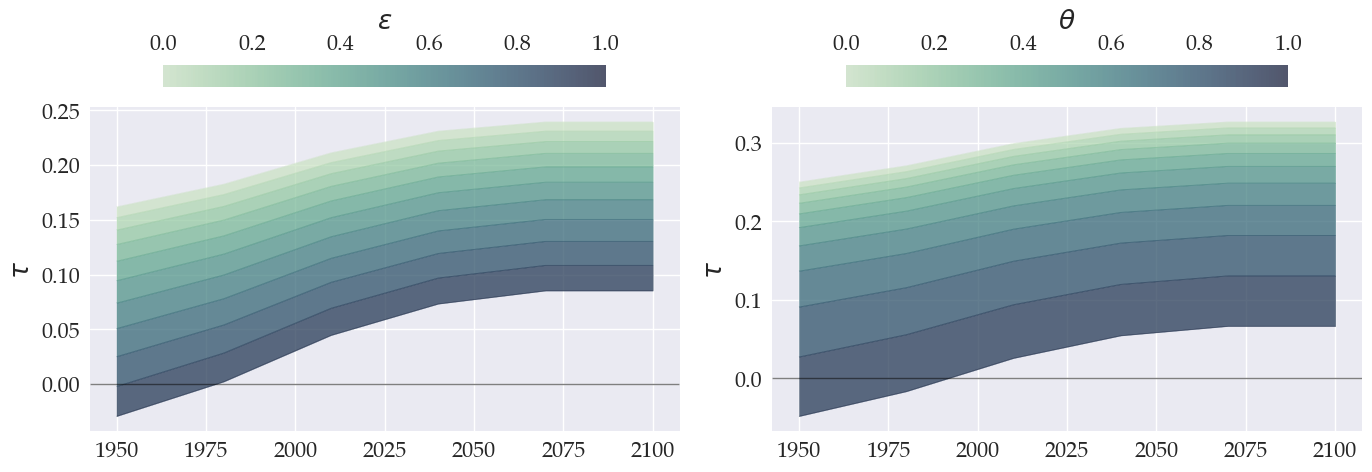

In [18]:
mult_graphs()
# Specify color map:
palette, mapAlpha = 'ch:start=.1,rot=-.5', .75
colormap = add_alpha_to_colormap(seaborn.color_palette(palette, as_cmap=True), alpha = mapAlpha)

# Create plot:
fig, axes = plt.subplots(1, 2, figsize = (14, 5));
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = τϵ, linewidth = .25, dashes=False, palette = palette, ax = ax, alpha = .75, legend = False);
for i in range(τϵ.shape[1]-1):
    ax.fill_between(τϵ.index, τϵ.iloc[:,i], τϵ.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau$');
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(ϵgrid), max(ϵgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\epsilon$');

ax = plt.subplot(1,2,2)
seaborn.lineplot(data = τθ, linewidth = .25, dashes=False, ax = ax, palette = palette, alpha = .75, legend = False);
for i in range(τθ.shape[1]-1):
    ax.fill_between(τθ.index, τθ.iloc[:,i], τθ.iloc[:,i+1], alpha = mapAlpha, color = ax.get_lines()[i].get_color())
dfAx(ax, .25, ylabel = '$\\tau$')
sm = plt.cm.ScalarMappable(cmap = colormap, norm = plt.Normalize(min(θgrid), max(θgrid)))
cbar = ax.figure.colorbar(sm, ax = ax, location = 'top', shrink = .75);
cbar.set_label('$\\theta$');

fig.tight_layout()
fig.savefig(os.path.join(d['figs'], 'policyPensionChar_Argentina.pdf'), edgecolor='k')

### 3.2. Utility as a function pension design

Report the level of utility as a function of $\epsilon, \theta$ relative to the baseline calibration. We do this for the baseline year $2010$. Report for the four different types: Workers (split into $i$ productivity types), retirees (split into $i$ productivity types), young hand-to-mouth consumers, and old hand-to-mouth consumers.

*1. Young workers:*

In [19]:
u0 = adjLabels(initialSolution['util1i']).xs(t0) # initial levels of utility
uRelative_ϵ = 100 * pd.concat([adjLabels(soli['util1i']).xs(t0) for soli in ϵsol.values()],axis=1).set_axis(ϵgrid, axis = "columns").div(u0,axis=0).T
uRelative_θ = 100 *pd.concat([adjLabels(soli['util1i']).xs(t0) for soli in θsol.values()],axis=1).set_axis(θgrid, axis = "columns").div(u0,axis=0).T

Plot:

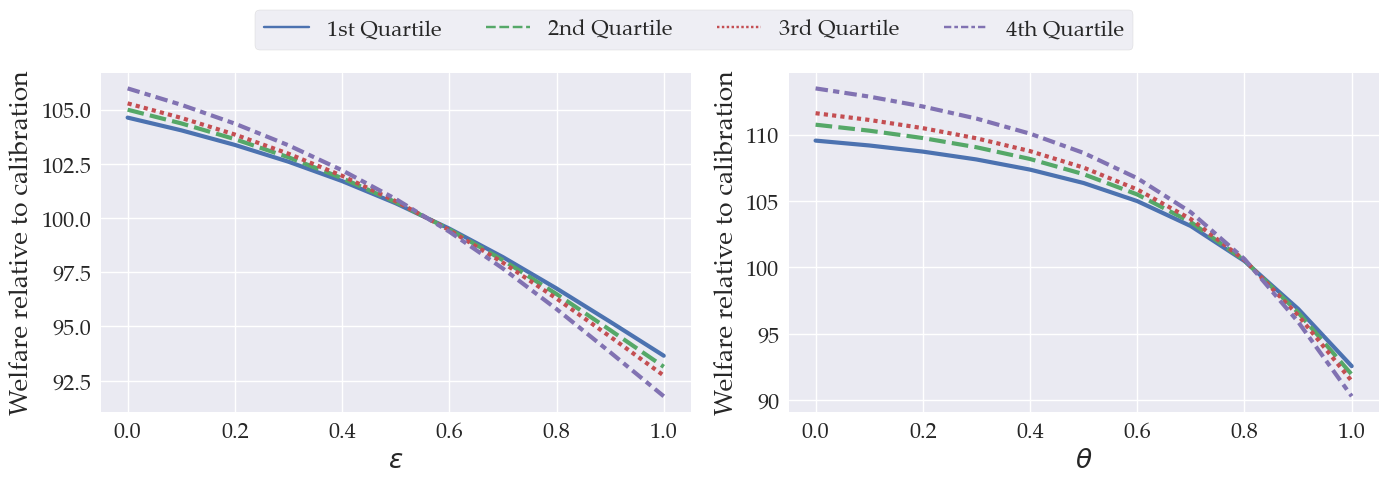

In [20]:
mult_graphs()
fig, axes = plt.subplots(1, 2, figsize = (14, 5));
ax = plt.subplot(1,2,1)
seaborn.lineplot(data = uRelative_ϵ, linewidth = 3, ax = ax, legend=True);
handles, labels = ax.get_legend_handles_labels()
ax.get_legend().remove();
ax.set_ylabel('Welfare relative to calibration');
ax = plt.subplot(1,2,2)
seaborn.lineplot(data = uRelative_θ, linewidth = 3, ax = ax, legend = False);
ax.set_ylabel('Welfare relative to calibration');
fig.legend(handles, labels,loc=9,ncol=ni,frameon=True)
fig.tight_layout();
fig.subplots_adjust(top=0.85);
fig.savefig(os.path.join(d['figs'], 'utilYougnPensionChar_Argentina.pdf'), edgecolor='k')